In [2]:
import numpy as np
import pandas as pd
import random as rand
from scipy import linalg
from scipy.sparse.linalg import eigs, LinearOperator
from scipy.sparse import random
from scipy.optimize import brute
import scipy.stats as stats
from os import listdir,getcwd
from functools import partial
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.patches import Rectangle
from collections import OrderedDict
import pandas as pd
from sklearn.model_selection import KFold
from IPython.display import Audio
from time import time
%matplotlib inline

In [ ]:
zhang_dir = getcwd()+'\\ZhangData'
data = np.zeros(132, dtype=[('neuron_id','a13'),
                                ('raster_data',np.float32,(419,1000)),
                                ('raster_info','a20',4),
                                ('stimulus_id','a15',419),
                                ('stimulus_position','a15',419),
                                ('combined_id_position','a15',419)])

for i,data_dir in enumerate(listdir(zhang_dir)):
    raster_data, raster_info, raster_labels = [zhang_dir+'\\'+data_dir+'\\'+my_dir for my_dir in listdir(zhang_dir+'\\'+data_dir)]
    neuron_id = data_dir[0:(len(data_dir)-12)]
    data_arr = pd.read_csv(raster_data,header=None).values
    labels_arr = pd.read_csv(raster_labels,header=0).values
    if data_arr.shape == (420,1000):
        data_arr = data_arr[0:(len(data_arr)-1)]
        labels_arr = labels_arr[0:(len(labels_arr)-1)]
    data[i] = (neuron_id, data_arr, pd.read_csv(raster_info).values, labels_arr[:,0],labels_arr[:,1],labels_arr[:,2])

In [ ]:
[x[0]  for x in data[['neuron_id']][0:3]]

#Get fourth run from first 3 neurons
[plt.plot(x[0][4]) for x in data[['raster_data']][0:3]]
plt.show()
[x[0] for x in data[['neuron_id']][0:3]]

In [ ]:
## for multiple neurons
y=[x['raster_data'][x[0]=='hand'] for x in data[['stimulus_id','raster_data']][:][:]]
plt.plot(y[0][0])
plt.plot(y[0][1])
plt.show()
#for single neurons
#[x[:,0] for x in data[['stimulus_id','raster_data']][0][0]]

In [ ]:
[plt.plot(x) for x in data['raster_data'][0][data['stimulus_id'][0]=='hand'][0:2]]
plt.show()
[plt.plot(x) for x in data['raster_data'][0][[0,9],:]]
plt.show()

In [ ]:
def addExponentialDecayToNeuronRead(neuron_read, rate_of_exp_decrease):
    activation = 0.0
    for i,x in enumerate(neuron_read):
        if x==1.0:
            activation+=1.0
        elif ((x==0.0) and (activation>0.0)):
            activation *= rate_of_exp_decrease
        if activation<0.:
            activation=0.
        neuron_read[i]=activation


def addExponentialDecay(speed,d=data):
    addExpDecay = partial(addExponentialDecayToNeuronRead, rate_of_exp_decrease = speed)
    for neuron in d:
        np.apply_along_axis(addExpDecay, axis = 1, arr = neuron['raster_data'])

In [ ]:
index_1018=data['raster_info'][:,3]=='1018'
index_1018

In [ ]:
index_1018=data['raster_info'][:,3]=='1018'
data_1018 = np.zeros(11, dtype=[('neuron_id','a13'),
                                ('raster_data',np.float32,(419,1000)),
                                ('raster_info','a20',4),
                                ('stimulus_id','a15',419),
                                ('stimulus_position','a15',419),
                                ('combined_id_position','a15',419)])
data_1018[np.arange(11)] = data[index_1018]

In [ ]:
np.save('data_1018',data_1018)

In [ ]:
def reshapeSignalsToOneTimeTrace(signal):
    (nUnits, nRuns, nTime) = signal.shape
    single_trace_signal = np.zeros((nUnits,nRuns*nTime))
    for i in np.arange(nRuns):
        single_trace_signal[:,(i*nTime):(i*nTime+nTime)] = signal[:,i,:].reshape((nUnits,nTime))
    return(single_trace_signal)

In [ ]:
seen = dict(zip(np.unique(data['raster_info'][:,3]),np.zeros(21)))
for runid in data['raster_info'][:,3]:
    seen[runid] = seen[runid]+1
    
seen

In [ ]:
teach = createTeacherSignal(data_1018)[0]

In [ ]:
names=['car', 'couch', 'face', 'flower', 'guitar', 'hand', 'kiwi']
stim_num = 8
x = [plt.plot(x[stim_num,:], label = names[i]) for i,x in enumerate(teach)]
print('Number of output nodes: '+str(len(x)))
print('Stimulus shown: '+data_1018[0]['stimulus_id'][stim_num])
plt.legend()
plt.show()

In [ ]:
teach_test = reshapeSignalsToOneTimeTrace(teach)
one_signal_data_test = reshapeSignalsToOneTimeTrace(test_data['raster_data'])

In [ ]:
teach_test.shape
one_signal_data_test.shape

In [ ]:
x = [plt.plot(x, label = names[i]) for i,x in enumerate(teach_test[:,0:5000])]
plt.legend()
plt.show()

neuron_ids = ['1','2','3','4','5','6','7','8','9','10','11']
x = [plt.plot(x,label = neuron_ids[i]) for i,x in enumerate(one_signal_data_test[:,0:5000])]
plt.legend()
plt.show()

In [ ]:
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')

In [ ]:
%matplotlib inline

In [5]:
data_exp_decay_1018 = np.load('data_1018.npy')
def getSpecificStimulus(sid, neuron_index = None, d=data_exp_decay_1018):
    if neuron_index==None:
        to_return = [x['raster_data'][x[0]==sid] for x in d[['stimulus_id','raster_data']][:][:]]
    else:
        to_return = [x['raster_data'][x[0]==sid] for x in d[['stimulus_id','raster_data']][neuron_index][:]]
    return(to_return)

def addExponentialDecayToNeuronRead(neuron_read, rate_of_exp_decrease):
    activation = 0.0
    for i,x in enumerate(neuron_read):
        if x==1.0:
            activation+=1.0
        elif ((x==0.0) and (activation>0.0)):
            activation *= rate_of_exp_decrease
        if activation<0.:
            activation=0.
        neuron_read[i]=activation

def addExponentialDecay(speed,d=data_exp_decay_1018):
    addExpDecay = partial(addExponentialDecayToNeuronRead, rate_of_exp_decrease = speed)
    for neuron in d:
        np.apply_along_axis(addExpDecay, axis = 1, arr = neuron['raster_data'])
    np.max(d['raster_data'])

def createBriefTeacherSignal(d=data_exp_decay_1018):
    ind_dict = dict(zip(['car', 'couch', 'face', 'flower', 'guitar', 'hand', 'kiwi'],np.arange(7)))
    teacher_signal = np.zeros(len(d), dtype = (np.float32,(7,419,1000)))
    increase = [1.0/(1.0+np.exp(-0.7*x)) for x in np.linspace(-10,10,100)]
    decrease = [1.0/(1.0+np.exp(0.7*x)) for x in np.linspace(-10,10,100)]
    for i, neuron in enumerate(d):
        for j in np.arange(419):
            stimulus_index = ind_dict[neuron['stimulus_id'][j]]
            stimulus_shown = int(neuron['raster_info'][0])
            teacher_signal[stimulus_index][i][stimulus_shown:stimulus_shown+100] = increase
            teacher_signal[stimulus_index][i][stimulus_shown+100:stimulus_shown+200] = decrease

    return (teacher_signal)

def createExtendedTeacherSignal(d=data_exp_decay_1018):
    ind_dict = dict(zip(['car', 'couch', 'face', 'flower', 'guitar', 'hand', 'kiwi'],np.arange(7)))
    teacher_signal = np.zeros(len(d), dtype = (np.float32,(7,419,1000)))
    increase = [1.0/(1.0+np.exp(-0.7*x)) for x in np.linspace(-10,10,100)]
    for i, neuron in enumerate(d):
        for j in np.arange(419):
            stimulus_index = ind_dict[neuron['stimulus_id'][j]]
            stimulus_shown = int(neuron['raster_info'][0])
            teacher_signal[stimulus_index][i][stimulus_shown:(stimulus_shown+100)] = increase
            teacher_signal[stimulus_index][i][(stimulus_shown+100):1000] = 1.0

    return (teacher_signal)

def createTimeSensitiveTeacherSignal(d=data_exp_decay_1018, num_bins = 10):
    ind_dict = dict(zip(['car', 'couch', 'face', 'flower', 'guitar', 'hand', 'kiwi'],np.arange(7)))
    teacher_signal = np.zeros((7*num_bins,419,1000))
    neuron = d[0]
    for j in np.arange(419):
        stimulus_num = ind_dict[neuron['stimulus_id'][j]]
        start_index = stimulus_num*num_bins
        stimulus_shown = int(neuron['raster_info'][0])
        bin_size = int((1000-stimulus_shown)/num_bins)
        for i in np.arange(start_index,start_index+num_bins):
            start = stimulus_shown+(i%num_bins)*bin_size
            teacher_signal[i,j,start:start+bin_size] = 1.0
    return (teacher_signal)    

def reshapeSignalsToOneTimeTrace(signal):
    (nUnits, nRuns, nTime) = signal.shape
    single_trace_signal = np.zeros((nUnits,nRuns*nTime))
    for i in np.arange(nRuns):
        single_trace_signal[:,(i*nTime):(i*nTime+nTime)] = signal[:,i,:].reshape((nUnits,nTime))
    return(single_trace_signal)

def calculateTotalAccuracy(y_target,y,nToSkip = 100):
    n_outputs = int(y_target.shape[0])
    n_bins = n_outputs/7
    n_time_steps = int(y_target.shape[1])
    n_cases = n_time_steps/1000
    time_additive_traces = np.zeros((7,500))
    bin_class_tp= np.zeros((7, n_bins))
    bin_class_fp= np.zeros((7, n_bins))
    bin_class_fn= np.zeros((7, n_bins))
    bin_class_tn= np.zeros((7, n_bins))
    bin_class_actual = np.zeros((7,n_bins))
    bin_class_sec_tp = np.zeros((7,n_bins))
    bin_size = 500/n_bins
    for j in np.arange((1000-nToSkip)%1000,n_time_steps,1000):
        start = j+500
        for i in np.arange(7):
            time_additive_traces[i,0:bin_size] = y[i*n_bins,start:start+bin_size]
            for k in np.arange(1,n_bins):
                time_additive_traces[i,k*bin_size:(bin_size+k*bin_size)] = reduce(lambda a,b: a+b,
                                                                                  y[i*n_bins+np.arange(0,k+1),start+k*bin_size:(start+bin_size+k*bin_size)])
        summed_traces = [np.sum(time_additive_traces[:,i*bin_size:i*bin_size+bin_size],axis=1)/bin_size for i in np.arange(n_bins)]
        [predicted_second,predicted_first] = np.argpartition(np.array(summed_traces).T,-2,0)[-2:]       
        correct=np.argmax([1. in i for i in y_target[:,start:start+500]])/n_bins
        for bin_i in np.arange(n_bins):
            if correct==predicted_first[bin_i]:
                bin_class_tp[correct,bin_i] +=1.
                bin_class_tn[np.arange(7)!=correct,bin_i]+=1.
                bin_class_sec_tp[correct,bin_i]+= 1.
            elif correct == predicted_second[bin_i]:
                bin_class_fp[correct,bin_i]+= 1.
                bin_class_sec_tp[correct,bin_i]+= 1.
                bin_class_fn[predicted_first[bin_i],bin_i]+=1.
            else:
                bin_class_fp[correct,bin_i]+= 1.
                bin_class_fn[predicted_first[bin_i],bin_i]+=1.
        bin_class_actual[correct,:]+=1.
    return(bin_class_tp,bin_class_fp,bin_class_tn,bin_class_fn,bin_class_actual,bin_class_sec_tp)

In [33]:
sub_t = T_test[:,np.arange(10000)]
sub_y = Y_test[:,np.arange(10000)]

In [68]:
np.repeat([[0,1,2],
           [3,4,5]],2,1)

array([[0, 0, 1, 1, 2, 2],
       [3, 3, 4, 4, 5, 5]])

In [71]:
n_outputs = int(sub_t.shape[0])
n_bins = n_outputs/7
n_time_steps = int(sub_t.shape[1])
n_cases = n_time_steps/1000
time_additive_traces = np.zeros((7,500))

total_traces = np.zeros((7,10000))
total_summed_traces = np.zeros((7,10000))
bin_size = 500/n_bins
x=np.arange(500)
for j in np.arange((1000-0)%1000,n_time_steps,1000):
    start = j+500
    for i in np.arange(7):
        time_additive_traces[i,0:bin_size] = sub_y[i*n_bins,start:start+bin_size]
        for k in np.arange(1,n_bins):
            time_additive_traces[i,k*bin_size:(bin_size+k*bin_size)] = reduce(lambda a,b: a+b,
                                                                                  sub_y[i*n_bins+np.arange(0,k+1),start+k*bin_size:(start+bin_size+k*bin_size)])
    total_traces[:,x]=0.
    total_traces[:,x+500] = time_additive_traces
    summed_traces = np.array([np.sum(time_additive_traces[:,i*bin_size:i*bin_size+bin_size],axis=1)/bin_size for i in np.arange(n_bins)])
    total_summed_traces[:,x]=0.
    total_summed_traces[:,x+500]= np.repeat(summed_traces.T,50,1)
    x+=1000

# [predicted_second,predicted_first] = np.argpartition(np.array(summed_traces).T,-2,0)[-2:]       
# correct=np.argmax([1. in i for i in sub_t[:,start:start+500]])/n_bins

In [72]:
total_summed_traces.shape

(7L, 10000L)

In [84]:
f, ((ax1,ax2)) = plt.subplots(1,2)
[ax2.plot(np.arange(0,7000),T_test[i,0:7000],c=rep_stim_colors[i],label = rep_labs[i],ls=':',linewidth=0.3) for i in np.arange(7*num_bins)]
[ax2.plot(np.arange(0,7000),total_summed_traces[i,0:7000],c=stim_colors[i],label = labs[i]) for i in np.arange(7)]
ax2.set_title("Target & Average Additive Traces for Each Bin - Cases 1-7")
ax2.set_xticks(np.arange(0,8000,1000))
ax2.set_ylim(-0.1,1.)
ax2.set_xlabel("Time (1000ms per stimuli exposure)")
ax2.set_ylabel("Output Activation")
handles, labels = ax2.get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax2.legend(by_label.values(), by_label.keys(), loc=3,
           ncol=7, mode="expand", borderaxespad=0., handlelength=0.5,handletextpad =0.0)


[ax1.plot(np.arange(0,7000),T_test[i,0:7000],c=rep_stim_colors[i],label = rep_labs[i],ls=':',linewidth=0.3) for i in np.arange(7*num_bins)]
[ax1.plot(np.arange(0,7000),total_traces[i,0:7000],c=stim_colors[i],label = labs[i]) for i in np.arange(7)]
ax1.set_title("Target & Time Additive Traces of Testing Output - Cases 1-7")
ax1.set_xlabel("Time (1000ms per stimuli exposure)")
ax1.set_ylabel("Output Activation")
ax1.set_ylim(-0.1,1.)
ax1.set_xticks(np.arange(0,8000,1000))
handles, labels = ax1.get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax1.legend(by_label.values(), by_label.keys(), loc=3,
           ncol=7, mode="expand", borderaxespad=0., handlelength=0.5,handletextpad =0.0)
plt.show()

In [85]:
f, (ax1) = plt.subplots(1)

[ax1.plot(np.arange(0,10000),T_test[i,0:10000],c=rep_stim_colors[i],label = rep_labs[i],ls=':',linewidth=0.3) for i in np.arange(7*num_bins)]
[ax1.plot(np.arange(0,10000),Y_test[i,0:10000],c=rep_stim_colors[i],label = rep_labs[i]) for i in np.arange(7*num_bins)]
ax1.set_title("Target & Testing Output - Cases 1-10")
ax1.set_xlabel("Time (1000ms per stimuli exposure)")
ax1.set_ylabel("Output Activation")
ax1.set_xticks(np.arange(0,11000,1000))
handles, labels = ax1.get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax1.legend(by_label.values(), by_label.keys(), loc=3,
           ncol=7, mode="expand", borderaxespad=0., handlelength=0.5,handletextpad =0.0)
plt.show()

In [13]:
teacher.shape

(70L, 419L, 1000L)

In [18]:
f, (ax1) = plt.subplots(1)

[ax1.plot(np.arange(0,1000),teacher[i,1,:],c=rep_stim_colors[i],label = rep_labs[i]) for i in np.arange(7*num_bins)]
ax1.set_title("Target Signal")
ax1.set_xlabel("Time (1000ms per stimuli exposure)")
ax1.set_ylabel("Output Activation")
ax1.set_xticks(np.arange(0,1100,100))
handles, labels = ax1.get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax1.legend(by_label.values(), by_label.keys())
plt.show()

In [102]:
print(tot_right[np.arange(7)!=0,0])
tot_right

[ 7.  6.  9.  6.  9.  6.]


array([[  7.,   9.,   9.,   8.,   7.,   7.,  10.,  12.,  14.,  10.],
       [  7.,   6.,   6.,   5.,  16.,  25.,  30.,  31.,  33.,  33.],
       [  6.,   4.,   4.,   7.,   6.,   7.,   9.,  11.,   7.,  11.],
       [  9.,  10.,   9.,  11.,   6.,  11.,  17.,  24.,  25.,  26.],
       [  6.,   7.,  19.,  20.,  29.,  33.,  31.,  31.,  32.,  30.],
       [  9.,  10.,  10.,   6.,  10.,  17.,  20.,  22.,  23.,  20.],
       [  6.,  11.,   5.,   5.,  14.,  19.,  25.,  32.,  26.,  33.]])

In [96]:
np.array([1,4,5])[np.arange(len([1,4,5]))!=0]

array([4, 5])

In [ ]:
added_traces = np.zeros((7,500))
for i in np.arange(7):
    added_traces[i] = reduce(lambda a,b: a+b, Y[i*35/7:i*35/7+35/7,500:1000])
[plt.plot(trace,c=cols[i]) for i,trace in enumerate(added_traces)]
plt.show()
[plt.plot(trace, c= rep_cols[i]) for i,trace in enumerate(Y[:,500:1000])]
plt.show()

In [3]:
tot_corr = 0
tot_test_corr = 0

In [19]:
seed = 275
nTimeUnits = 1000
nTrainRuns = 300
nTestRuns = 419-nTrainRuns
nToSkip = 10000
inputSize = 12
num_bins = 10
kf = KFold(n_splits=3)

rvs = stats.uniform(-1,2).rvs # uniform distribution between [-1,1]

In [20]:
cmap = get_cmap("Set1")
stim_colors = [cmap(i) for i in np.linspace(0,1,7)]
stim_colors[6] = (44./255.,160./255.,44./255.,1.)
rep_stim_colors = np.repeat(stim_colors,num_bins,0)

bin_colors = [cmap(i) for i in np.linspace(0,1,num_bins)]

labs = ['car', 'couch', 'face', 'flower', 'guitar', 'hand', 'kiwi']
rep_labs = np.repeat(labs,num_bins)

%matplotlib auto

Using matplotlib backend: Qt5Agg


In [21]:
dfm=pd.read_csv('parameter_history.csv', header=0)

In [123]:
# Tunable parameters
res_size = 150
scale_res = 0.79
alpha = 5.1 # regularization rate
scale_in = 2.64
scale_b = 2.0
scale_noise = 0.
exp_decay_rate = 0.995
scale_input_data = True

rand.seed(seed) # set the seed
np.random.seed(seed)

last_row = dfm.shape[0]-1
max_tot_corr = max(dfm.loc[:,'avg_train_acc'])
max_tot_test_corr = max(dfm.loc[:,'avg_test_acc'])

In [23]:
# Preparing input and teacher data
#data_exp_decay_1018 = data_1018.copy()
data_exp_decay_1018 = np.load('data_1018.npy')
addExponentialDecay(exp_decay_rate,data_exp_decay_1018)

In [24]:
if scale_input_data:
    for neuron in data_exp_decay_1018['raster_data']:
        neuron /= np.max(neuron)
input_data = np.concatenate((np.ones((1,419,1000)),data_exp_decay_1018['raster_data']),axis=0) # vertically concatenate ones as first input

In [25]:
# Create output signal 
teacher = createTimeSensitiveTeacherSignal(data_exp_decay_1018, num_bins) # Because each of these 11 neurons saw the same stimuli, only need one

In [26]:
def trainAndTestOnSubsetOfCases(train_case_indices, test_case_indices):
    nTrainRuns = len(train_case_indices)
    nTestRuns = len(test_case_indices)
    
    W = random(res_size,res_size,density = 0.05, data_rvs = rvs).A # uniformly distributed
    vals, vecs = np.absolute(eigs(W))
    l = max(vals) # eigenvalues
    W /= l # divide W by it's largest eigenvalue
    W *= scale_res # scale W

    W_in = random(res_size,inputSize,density=0.5, data_rvs = rvs).A
    W_in *= scale_in

    b = np.array(rvs(res_size)).reshape(res_size,1)
    b *= scale_b

    ## State Harvesting
    X = np.zeros((res_size,nTrainRuns*nTimeUnits))
    M = np.zeros((res_size+inputSize,nTrainRuns*nTimeUnits-nToSkip))
    T = np.zeros((7*num_bins,nTrainRuns*nTimeUnits-nToSkip))

    for j, run in enumerate(train_case_indices):
        for i in np.arange(1, nTimeUnits):
            index = j*nTimeUnits+i
            W_dot_Xn = np.dot(W,X[:,index-1].reshape((res_size,1)))
            Win_dot_Un = np.dot(W_in, input_data[:,run,i].reshape((inputSize,1)))
            noise = np.random.normal(0,scale_noise,size=res_size).reshape((res_size,1))
            X[:,index] = np.tanh(W_dot_Xn+Win_dot_Un+b+noise).reshape(res_size)
            if index >=nToSkip:
                M[:,index-nToSkip]=np.concatenate((input_data[:,run,i],X[:,index]),axis=0)
                T[:,index-nToSkip]=teacher[:,run,i].reshape(7*num_bins)
    #Y_dot_Xt = reduce(lambda x,y:x+y, [np.dot(subset_teacher[:,i,:].reshape(70,1000),X[i*1000:i*1000+1000,:].T) for i in np.arange(419)])
    Y_dot_Xt = np.dot(T,M.T)
    X_dot_Xt_w_regularization = np.dot(M,M.T)+alpha*np.identity(res_size+inputSize)

    # Use Ridge Regression to calculate output Weights
    W_out = np.dot(Y_dot_Xt, linalg.inv(X_dot_Xt_w_regularization))
    Y = np.dot(W_out,M)
    
    ## Testing
    
    X_test = np.zeros((res_size,nTestRuns*nTimeUnits))
    M_test = np.zeros((res_size+inputSize,nTestRuns*nTimeUnits))
    T_test = np.zeros((7*num_bins,nTestRuns*nTimeUnits))

    for j, run in enumerate(test_case_indices):
        for i in np.arange(1, nTimeUnits):
            index = j*nTimeUnits+i
            W_dot_Xn = np.dot(W,X_test[:,index-1].reshape((res_size,1)))
            Win_dot_Un = np.dot(W_in, input_data[:,run,i].reshape((inputSize,1)))
            noise = np.random.normal(0,scale_noise,size=res_size).reshape((res_size,1))
            X_test[:,index] = np.tanh(W_dot_Xn+Win_dot_Un+b+noise).reshape(res_size)
            M_test[:,index] = np.concatenate((input_data[:,run,i],X_test[:,index]),axis=0)
            T_test[:,index] = teacher[:,run,i].reshape(7*num_bins)

    Y_test=np.dot(W_out,M_test)
    
    [bin_class_train_tp,bin_class_fp,bin_class_tn,bin_class_fn,bin_class_train_actual,bin_class_sec_tp] = calculateTotalAccuracy(T,Y,nToSkip)
    [bin_class_tp,bin_class_fp,bin_class_tn,bin_class_fn,bin_class_actual,bin_class_sec_tp] = calculateTotalAccuracy(T_test,Y_test,0)
    
    train_tpr_bin = np.sum(bin_class_train_tp,0)/np.sum(bin_class_train_actual,0)
    train_tpr = max(train_tpr_bin)
    
    return([train_tpr_bin,train_tpr,bin_class_tp,bin_class_fp,bin_class_tn,bin_class_fn,bin_class_actual,bin_class_sec_tp,T_test,Y_test])

In [208]:
%matplotlib inline

In [172]:
print(np.concatenate([tot_tp/tot_counts,tot_sec_tp/tot_counts]).shape)

(14L, 10L)


In [74]:

markers = np.repeat(['o','^'],7)
tile_labs = np.tile(labs,2)
markers
np.concatenate([stim_colors,stim_colors])

array([[ 0.89411765,  0.10196078,  0.10980392,  1.        ],
       [ 0.21568627,  0.49411765,  0.72156863,  1.        ],
       [ 0.59607843,  0.30588235,  0.63921569,  1.        ],
       [ 1.        ,  0.49803922,  0.        ,  1.        ],
       [ 0.65098039,  0.3372549 ,  0.15686275,  1.        ],
       [ 0.96862745,  0.50588235,  0.74901961,  1.        ],
       [ 0.17254902,  0.62745098,  0.17254902,  1.        ],
       [ 0.89411765,  0.10196078,  0.10980392,  1.        ],
       [ 0.21568627,  0.49411765,  0.72156863,  1.        ],
       [ 0.59607843,  0.30588235,  0.63921569,  1.        ],
       [ 1.        ,  0.49803922,  0.        ,  1.        ],
       [ 0.65098039,  0.3372549 ,  0.15686275,  1.        ],
       [ 0.96862745,  0.50588235,  0.74901961,  1.        ],
       [ 0.17254902,  0.62745098,  0.17254902,  1.        ]])

In [322]:
%matplotlib auto

Using matplotlib backend: Qt5Agg


In [346]:
print(np.round(np.max(tot_sec_tp/tot_counts,0),2))
print(np.round(np.mean(tot_sec_tp/tot_counts,0),2))
print(np.round(np.sum(tot_tp,0)/np.sum(tot_counts,0),3))


C:\Users\Brooke\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: RuntimeWarning: invalid value encountered in divide
  if __name__ == '__main__':
C:\Users\Brooke\Anaconda2\lib\site-packages\numpy\core\fromnumeric.py:57: RuntimeWarning: invalid value encountered in rint
  return getattr(obj, method)(*args, **kwds)


[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]


C:\Users\Brooke\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: invalid value encountered in divide
  from ipykernel import kernelapp as app
C:\Users\Brooke\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: invalid value encountered in divide
  app.launch_new_instance()


In [49]:
%matplotlib inline

In [187]:
f, ((ax1,ax2)) = plt.subplots(1,2)

ax1.bar(np.arange(0,10),np.mean(tot_tp/tot_counts,0),color=stim_colors[1])
ax1.set_xticks(np.arange(10))
ax1.set_xticklabels(bin_labs)
#ax1.set_ylim(0.,0.46)
vals = ax1.get_yticks()
ax1.set_yticklabels(['{:3.2f}%'.format(x*100) for x in vals])
ax1.set_ylabel("Percent of runs correctly classified (true positive rate)")
ax1.set_xlabel("Time after stimulus was shown")
ax1.set_title("Average classification accuracy per time bin")

inds = np.argsort(np.mean(tot_tp/tot_counts,1))[::-1]
ax2.bar(np.arange(7),np.mean(tot_tp/tot_counts,1)[inds],color=np.array(stim_colors)[inds])
ax2.set_xticks(np.arange(7))
ax2.set_xticklabels(np.array(labs)[inds])
#ax2.set_ylim(0.,0.46)
vals = ax2.get_yticks()
ax2.set_yticklabels(['{:3.2f}%'.format(x*100) for x in vals])
ax2.set_ylabel("Percent of runs correctly classified (true positive rate)")
ax2.set_xlabel("Stimulus")
ax2.set_title("Average classification accuracy per stimulus")

plt.show()

(0.89411764705882357, 0.10196078431372549, 0.10980392156862745, 1.0, 1.1)

In [239]:
f, ((ax1,ax2)) = plt.subplots(1,2)
width = 0.35

inds = np.argsort(np.mean(tot_sec_tp/tot_counts,1))[::-1]
ax1.bar(np.arange(7),np.mean(tot_tp/tot_counts,1)[inds]-(1./7.),width,color=np.array(stim_colors)[inds],edgecolor='white')
ax1.bar(np.arange(7)+width,np.mean(tot_sec_tp/tot_counts,1)[inds]-(2./7.),width,color=np.array(stim_colors)[inds], edgecolor='white')
ax1.set_xticks(np.arange(7)+width/2)
ax1.set_xticklabels(np.array(labs)[inds])
ax1.set_ylim(-0.01,0.57)
vals = ax1.get_yticks()
ax1.set_yticklabels(['{:3.2f}%'.format(x*100) for x in vals])
ax1.set_ylabel("Percent of runs correctly classified")
ax1.set_title("Average accuracy over all time bins")
ax1.set_xlabel("Stimulus")

inds = np.argsort(np.max(tot_sec_tp/tot_counts,1))[::-1]
ax2.bar(np.arange(7),np.max(tot_tp/tot_counts,1)[inds]-(1./7.),width,color=np.array(stim_colors)[inds], edgecolor='white')
ax2.bar(np.arange(7)+width,np.max(tot_sec_tp/tot_counts,1)[inds]-(2./7.),width,color=np.array(stim_colors)[inds], edgecolor='white')
ax2.set_xticks(np.arange(7)+width/2)
ax2.set_xticklabels(np.array(labs)[inds])
ax2.set_ylim(-0.01,0.57)
vals = ax2.get_yticks()
ax2.set_yticklabels(['{:3.2f}%'.format(x*100) for x in vals])
ax2.set_ylabel("Percent of runs correctly classified")
ax2.set_xlabel("Stimulus")
ax2.set_title("Maximum accuracy for any time bin")

plt.suptitle("Classification Accuracies Above Chance Per Stimulus")
plt.show()

In [254]:
max(np.mean(tot_sec_tp/tot_counts,0))

0.62348566220746682

In [251]:
print(np.round(tot_tp/tot_counts-1./7.,3))
print(np.max(tot_tp/tot_counts-1./7.))
print(np.round(tot_sec_tp/tot_counts-2./7.,3))

print(np.max(tot_sec_tp/tot_counts-2./7.))

[[-0.052 -0.052 -0.052 -0.052 -0.006 -0.052  0.039  0.13   0.175  0.084]
 [-0.038 -0.09  -0.038  0.12   0.226  0.278  0.489  0.331  0.331  0.489]
 [-0.032  0.024 -0.087  0.024 -0.032  0.024 -0.032 -0.087  0.024  0.024]
 [ 0.     0.    -0.048 -0.095  0.048  0.143  0.143  0.238  0.286  0.333]
 [-0.097 -0.143  0.084  0.084  0.266  0.403  0.312  0.357  0.448  0.494]
 [ 0.007  0.057 -0.043 -0.093  0.057  0.207  0.307  0.257  0.257  0.257]
 [ 0.024  0.024 -0.032  0.024  0.19   0.079  0.19   0.302  0.19   0.468]]
0.493506493506
[[-0.149 -0.013  0.032  0.032  0.123  0.032  0.123  0.26   0.169  0.032]
 [ 0.083  0.083  0.083  0.241  0.346  0.451  0.398  0.451  0.556  0.451]
 [-0.063  0.048 -0.063 -0.063 -0.119  0.103 -0.063 -0.063  0.048  0.048]
 [ 0.048 -0.048  0.048  0.    -0.048  0.048  0.095  0.238  0.238  0.381]
 [-0.104 -0.058  0.032  0.169  0.26   0.351  0.396  0.442  0.442  0.442]
 [-0.036  0.064  0.014  0.064  0.064  0.264  0.564  0.514  0.364  0.364]
 [ 0.048  0.103  0.103 -0.063  0.21

In [213]:
f, ((ax1,ax2)) = plt.subplots(1,2)
width = 0.35

ax1.bar(np.arange(0,10)+width,np.max(tot_tp/tot_counts,0),width,color=stim_colors[1], edgecolor='white')
ax1.bar(np.arange(0,10),np.max(tot_sec_tp/tot_counts,0),width,color=stim_colors[1], edgecolor='white')
ax1.set_xticks(np.arange(10)+width/2)
ax1.set_xticklabels(bin_labs)
#ax1.set_ylim(0.,0.66)
vals = ax1.get_yticks()
ax1.set_yticklabels(['{:3.2f}%'.format(x*100) for x in vals])
ax1.set_ylabel("Percent of runs correctly classified (true positive rate)")
ax1.set_xlabel("Time after stimulus was shown")
ax1.set_title("Maximum classification accuracy of any stimulus per time bin")

inds = np.argsort(np.max(tot_tp/tot_counts,1))[::-1]
ax2.bar(np.arange(7)+width,np.max(tot_tp/tot_counts,1)[inds],width,color=np.array(stim_colors)[inds], edgecolor='white')
ax2.bar(np.arange(7),np.max(tot_sec_tp/tot_counts,1)[inds],width,color=np.array(stim_colors)[inds], edgecolor='white')
ax2.set_xticks(np.arange(7)+width/2)
ax2.set_xticklabels(np.array(labs)[inds])
#ax2.set_ylim(0.,0.66)
vals = ax2.get_yticks()
ax2.set_yticklabels(['{:3.2f}%'.format(x*100) for x in vals])
ax2.set_ylabel("Percent of runs correctly classified (true positive rate)")
ax2.set_xlabel("Stimulus")
ax2.set_title("Maximum classification accuracy of any time bin per stimulus")

plt.show()

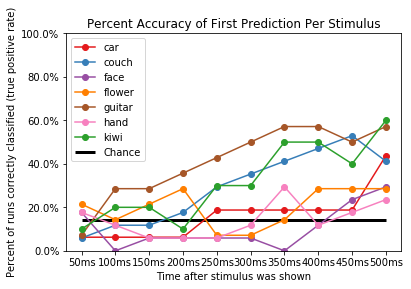

In [85]:
[plt.plot(x, '-o',label =labs[i], c=stim_colors[i]) for i,x in enumerate(tot_tp/tot_counts)]
plt.hlines(1./7.,0,9,label = "Chance",linewidth=3.0)
plt.legend()
plt.gca().yaxis.set_major_formatter(formatter)
plt.ylim([0,1])
plt.xticks(np.arange(10),bin_labs)
plt.ylabel("Percent of runs correctly classified (true positive rate)")
plt.xlabel("Time after stimulus was shown")
plt.title("Percent Accuracy of First Prediction Per Stimulus")
plt.show()

In [185]:
f, ((ax1,ax2)) = plt.subplots(1,2)

[ax1.plot(x, '-o',label =labs[i], c=stim_colors[i]) for i,x in enumerate(tot_tp/tot_counts)]
ax1.hlines(1./7.,0,9,label = "Chance",linewidth=3.0)
ax1.legend()
ax1.set_ylim(0.,1.)
vals = ax1.get_yticks()
ax1.set_yticklabels(['{:3.2f}%'.format(x*100) for x in vals])
ax1.set_xticks(np.arange(10))
ax1.set_xticklabels(bin_labs)
ax1.set_ylabel("Percent of runs correctly classified (true positive rate)")
ax1.set_xlabel("Time after stimulus was shown")
ax1.set_title("Percent Accuracy of First Prediction Per Stimulus")

[ax2.plot(x, '-o', label=labs[i],c=stim_colors[i]) for i,x in enumerate(tot_sec_tp/tot_counts)]
ax2.hlines(2./7.,0,9,label = "Chance",linewidth=3.0)
ax2.legend()
ax2.set_ylim(0.,1.)
vals = ax2.get_yticks()
ax2.set_yticklabels(['{:3.2f}%'.format(x*100) for x in vals])
ax2.set_xticks(np.arange(10))
ax2.set_xticklabels(bin_labs)
ax2.set_ylabel("Percent of runs correctly classified (true positive rate)")
ax2.set_xlabel("Time after stimulus was shown")
ax2.set_title("Percent Accuracy of First or Second Prediction Per Stimulus")
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None)
plt.show()



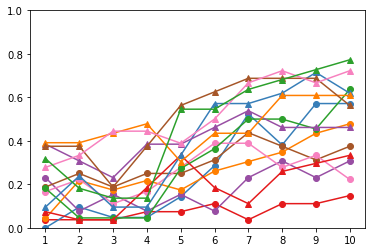

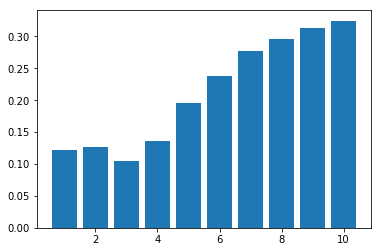

In [75]:
[plt.plot(x, marker=markers[i], label=tile_labs[i],c=np.concatenate([stim_colors,stim_colors])[i]) for i,x in enumerate(np.concatenate([tot_tp/tot_counts,tot_sec_tp/tot_counts]))]
plt.ylim([0,1])
plt.xticks(np.arange(10),np.arange(1,11))
plt.show()


plt.bar(np.arange(1,len(tot_sec_tp[0])+1),np.sum(tot_sec_tp+tot_tp,0)/419)
plt.show()

In [46]:
tot_accuracies = np.zeros((3,2))
bin_train_accuracies = np.zeros((3,num_bins))
bin_test_accuracies = np.zeros((3,num_bins))

In [122]:
np.sum(bin_class_tp,0)/np.sum(bin_class_actual,0)

array([ 0.13571429,  0.17142857,  0.1       ,  0.15      ,  0.21428571,
        0.28571429,  0.32857143,  0.30714286,  0.35      ,  0.37857143])

In [76]:
from matplotlib.ticker import FuncFormatter

def to_percent(y, position):
    # Ignore the passed in position. This has the effect of scaling the default
    # tick locations.
    s = str(100 * y)

    # The percent symbol needs escaping in latex
    if plt.rcParams['text.usetex'] is True:
        return s + r'$\%$'
    else:
        return s + '%'
    
formatter = FuncFormatter(to_percent)

# Set the formatter


In [71]:
bin_labs=['500-550ms','550-600ms','600-650ms','650-700ms','700-750ms','750-800ms','800-850ms','850-900ms','900-950ms','950-1000ms']
bin_labs=['50ms','100ms','150ms','200ms','250ms','300ms','350ms','400ms','450ms','500ms']

In [249]:
%matplotlib auto

Using matplotlib backend: Qt5Agg


In [203]:
np.sum(tot_sec_tp,0)/np.sum(tot_counts,0) - np.mean(tot_sec_tp/tot_counts,0)

array([-0.00364168, -0.0041055 ,  0.00011012,  0.00297117,  0.00130196,
       -0.00353156,  0.00071987,  0.00316809, -0.00205709, -0.0014392 ])

In [221]:
plt.bar(np.arange(7),np.arange(7),color = stim_colors)

<Container object of 7 artists>

In [225]:
plt.plot(np.mean(tot_tp/tot_counts,0)-(1./7.),'-o',color = stim_colors[3],label='First Prediction Average')
plt.plot(np.mean(tot_sec_tp/tot_counts,0)-(2./7.),'--o',color = stim_colors[3],label='First or Second Prediction Average')

plt.plot(np.max(tot_tp/tot_counts,0)-(1./7.),'-o',color = stim_colors[1],label='First Prediction Maximum')

plt.plot(np.max(tot_sec_tp/tot_counts,0)-(2./7.),'--o',color = stim_colors[1],label='First or Second Prediction Maximum')
plt.gca().yaxis.set_major_formatter(formatter)
plt.xticks(np.arange(10),bin_labs)
plt.ylabel("Percent of runs correctly classified above chance")
plt.xlabel("Time after stimulus was shown")
plt.legend()
plt.title("Average and Maximum Percent Accuracy Above Chance")

plt.show()

In [206]:
plt.plot(np.max(tot_tp/tot_counts,0)-(1./7.),'-o',label='First Prediction')

plt.plot(np.max(tot_sec_tp/tot_counts,0)-(2./7.),'-o',label='First or Second Prediction')
plt.gca().yaxis.set_major_formatter(formatter)
plt.xticks(np.arange(10),bin_labs)
plt.ylabel("Percent of runs correctly classified above chance")
plt.xlabel("Time after stimulus was shown")
plt.legend()
plt.title("Maximum Percent Accuracy Above Chance")

plt.show()

In [183]:
%matplotlib auto

Using matplotlib backend: Qt5Agg


[ 0.152  0.143  0.124  0.162  0.2    0.324  0.352  0.333  0.362  0.381]
[ 0.152  0.143  0.124  0.162  0.2    0.324  0.352  0.333  0.362  0.381]
[ 0.387  0.371  0.333  0.408  0.47   0.63   0.659  0.64   0.667  0.684]


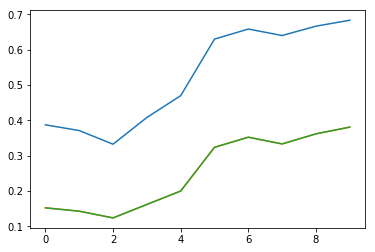

In [119]:
per_bin_accuracy=np.sum((tot_tp+tot_tn)/(tot_tp+tot_tn+tot_fp+tot_fn),0)/7
per_bin_precision = np.sum(tot_tp,0)/np.sum(tot_tp+tot_fp,0)
per_bin_recall = np.sum(tot_tp,0)/np.sum(tot_tp+tot_fn,0)
print(np.round(per_bin_precision,3))
print(np.round(per_bin_recall,3))
print(np.round(per_bin_accuracy,3))
[plt.plot(x) for x in [per_bin_accuracy,per_bin_precision,per_bin_recall]]
plt.show()

In [20]:
for train_index, test_index in kf.split(np.arange(419)):
    train_ind = train_index
    test_ind = test_index
    
[train_tpr_bin,train_tpr,bin_class_tp,bin_class_fp, bin_class_tn,bin_class_fn,
     bin_class_actual,bin_class_sec_tp,T_test,Y_test] = trainAndTestOnSubsetOfCases(train_ind, test_ind)

In [145]:
np.unique(data_exp_decay_1018['stimulus_id'][0][train], return_counts=True)

(array(['car', 'couch', 'face', 'flower', 'guitar', 'hand', 'kiwi'], 
       dtype='|S15'), array([36, 41, 41, 41, 38, 42, 40], dtype=int64))

In [144]:
int(419*2/3)/7

39

In [158]:
train = np.random.choice(np.arange(419), size = int(419*2/3), replace=False)
test = []
for x in np.arange(419):
    if x not in train:
        test.append(x)
test = np.array(test)
np.unique(data_exp_decay_1018['stimulus_id'][0][train], return_counts=True)

(array(['car', 'couch', 'face', 'flower', 'guitar', 'hand', 'kiwi'], 
       dtype='|S15'), array([38, 41, 42, 39, 37, 40, 42], dtype=int64))

In [181]:
print(np.round((np.mean(tot_tp/tot_counts,0)),2))
#print((np.max(tot_tp/tot_counts,0)))

[ 0.12  0.12  0.11  0.14  0.25  0.3   0.35  0.36  0.39  0.45]


In [159]:
start = time()
i=0
tot_fp = np.zeros((7,num_bins))
tot_fn = np.zeros((7,num_bins))
tot_tn = np.zeros((7,num_bins))
tot_tp = np.zeros((7,num_bins))
tot_counts = np.zeros((7,num_bins))
tot_sec_tp = np.zeros((7,num_bins))
for train_index, test_index in [[train,test]]:
    [train_tpr_bin,train_tpr,bin_class_tp,bin_class_fp, bin_class_tn,bin_class_fn,
     bin_class_actual,bin_class_sec_tp,T_test,Y_test] = trainAndTestOnSubsetOfCases(train_index, test_index)
    tot_tp+=bin_class_tp
    tot_fp+=bin_class_fp
    tot_tn+=bin_class_tn
    tot_fn+=bin_class_fn
    tot_counts+=bin_class_actual
    tot_sec_tp+=bin_class_sec_tp
    tot_accuracies[i,:] = [train_tpr,max(np.sum(bin_class_tp,0)/np.sum(bin_class_actual,0))]
    bin_train_accuracies[i,:] = train_tpr_bin
    bin_test_accuracies[i,:] = np.sum(bin_class_tp,0)/np.sum(bin_class_actual,0)
    print(i)
    i+=1
    
bin_train_acc = np.mean(bin_train_accuracies,axis=0)
bin_test_acc = np.mean(bin_test_accuracies,axis=0)
[avg_train_acc,avg_test_acc] = np.mean(tot_accuracies,axis=0)
print("Train: "+str(np.round(bin_train_acc,2))+'\n'+"Test: "+str(np.round(bin_test_acc,2)))
print("Train, Test Maximum Accuracy: "+str(np.round(np.mean(tot_accuracies,axis=0),2)))
print("First or Second bin accuracy: "+str(np.round(np.sum(tot_sec_tp,0)/np.sum(tot_counts,0),2)))
print("Test Change: "+str(avg_test_acc-max_tot_test_corr))
print("This took "+str((time()-start)/60)+" minutes")
Audio(url='chime.wav', autoplay=True)

0
Train: [ 0.18  0.19  0.16  0.17  0.17  0.18  0.19  0.19  0.18  0.17]
Test: [ 0.04  0.04  0.04  0.05  0.08  0.1   0.12  0.12  0.13  0.15]
Train, Test Maximum Accuracy: [ 0.19  0.15]
First or Second bin accuracy: [ 0.26  0.31  0.32  0.34  0.41  0.51  0.56  0.61  0.62  0.6 ]
Test Change: -0.258033573141
This took 0.924216663837 minutes


In [ ]:
parameter_names = ['scale_input_data','num_bins','res_size','scale_res','alpha','scale_in','scale_b','scale_noise',
                   'exp_decay_rate','avg_train_acc','bin_train_acc','avg_test_acc','bin_test_acc']
parameter_vals = [scale_input_data,num_bins,res_size,scale_res,alpha,scale_in,scale_b,
                  scale_noise,exp_decay_rate,avg_train_acc,bin_train_acc,avg_test_acc,bin_test_acc]
dfm = dfm.append(dict(zip(parameter_names,parameter_vals)),ignore_index=True)

In [ ]:
dfm.to_csv('parameter_history.csv')

In [ ]:
dfm.tail(3)

In [ ]:
dfm.sort_values('avg_test_acc',ascending=False)

In [ ]:
inv_leg = Rectangle((0, 0), 0, 0, alpha=0.0)

f, ((ax1,ax2,ax3), (ax4,ax5,ax6)) = plt.subplots(2,3)
[ax1.plot(np.arange(1000,4000),X[i,1000:4000]) for i in np.arange(1,5)]
ax1.set_title("Subset Reservoir Dynamics 1-4")

ax4.bar(np.arange(len(bin_corr)),bin_corr)
ax4.set_title("Training Accuracy Per Bin")
ax4.set_ylim([0,1])

[ax2.plot(np.arange(0,10000),T[i,0:10000],c=rep_stim_colors[i],label = rep_labs[i],ls=':') for i in np.arange(7*num_bins)]
[ax2.plot(np.arange(0,10000),Y[i,0:10000],c=rep_stim_colors[i],label = rep_labs[i]) for i in np.arange(7*num_bins)]
ax2.set_title("Teacher & Training Output - Cases 1-10")
handles, labels = ax2.get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax2.legend(by_label.values(), by_label.keys(), loc=3,
           ncol=7, mode="expand", borderaxespad=0., handlelength=0.5,handletextpad =0.0)

[ax5.plot(np.arange(10000,20000),T[i,10000:20000],c=rep_stim_colors[i],label = rep_labs[i],ls=':') for i in np.arange(7*num_bins)]
[ax5.plot(np.arange(10000,20000),Y[i,10000:20000],c=rep_stim_colors[i],label = rep_labs[i]) for i in np.arange(7*num_bins)]
ax5.set_title("Teacher & Training Output Cases 11-20")
handles, labels = ax5.get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax5.legend(by_label.values(), by_label.keys(), loc=3,
           ncol=7, mode="expand", borderaxespad=0., handlelength=0.5,handletextpad =0.0)


[ax3.plot(np.arange(8000,9050),T[i,8000:9050],c=bin_colors[i%num_bins],label = labs[i/num_bins]) for i in np.arange(6*num_bins,7*num_bins)]
[ax3.plot(np.arange(8000,9050),Y[i,8000:9050],c=bin_colors[i%num_bins],label = labs[i/num_bins]) for i in np.arange(6*num_bins,7*num_bins)]
ax3.set_title("8th Train Case Model Output")
handles, labels = ax3.get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax3.legend([inv_leg], by_label.keys(), handlelength=0.)

[ax6.plot(np.arange(13000,14050),T[i,13000:14050],c=bin_colors[i%num_bins],label = labs[i/num_bins]) for i in np.arange(4*num_bins,5*num_bins)]
[ax6.plot(np.arange(13000,14050),Y[i,13000:14050],c=bin_colors[i%num_bins],label = labs[i/num_bins]) for i in np.arange(4*num_bins,5*num_bins)]
ax6.set_title("13th Train Case Model Output")
handles, labels = ax6.get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax6.legend([inv_leg], by_label.keys(), handlelength=0.)

plt.suptitle('Overall Training Accuracy: '+str(np.round(tot_corr,3)) + ", Change: "+str(np.round(tot_corr-max_tot_corr,3))+ 
             ", Time Binned Accuracies: "+str(np.round(bin_corr,3)))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.4)
mng = plt.get_current_fig_manager()
mng.window.showMaximized()
plt.show()

In [ ]:
f, ((ax1,ax2,ax3), (ax4,ax5,ax6)) = plt.subplots(2,3)
[ax1.plot(np.arange(1000,4000),X_test[i,1000:4000]) for i in np.arange(1,5)]
ax1.set_title("Subset Reservoir Dynamics 1-4")

ax4.bar(np.arange(len(bin_test_corr)),bin_test_corr)
ax4.set_title("Testing Accuracy Per Bin")
ax4.set_ylim([0,1])

[ax2.plot(np.arange(0,10000),T_test[i,0:10000],c=rep_stim_colors[i],label = rep_labs[i],ls=':') for i in np.arange(7*num_bins)]
[ax2.plot(np.arange(0,10000),Y_test[i,0:10000],c=rep_stim_colors[i],label = rep_labs[i]) for i in np.arange(7*num_bins)]
ax2.set_title("Teacher & Testing Output - Cases 1-10")
handles, labels = ax2.get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax2.legend(by_label.values(), by_label.keys(), loc=3,
           ncol=7, mode="expand", borderaxespad=0., handlelength=0.5,handletextpad =0.0)

[ax5.plot(np.arange(10000,20000),T_test[i,10000:20000],c=rep_stim_colors[i],label = rep_labs[i],ls=':') for i in np.arange(7*num_bins)]
[ax5.plot(np.arange(10000,20000),Y_test[i,10000:20000],c=rep_stim_colors[i],label = rep_labs[i]) for i in np.arange(7*num_bins)]
ax5.set_title("Teacher & Testing Output Cases 11-20")
handles, labels = ax5.get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax5.legend(by_label.values(), by_label.keys(), loc=3,
           ncol=7, mode="expand", borderaxespad=0., handlelength=0.5,handletextpad =0.0)


[ax3.plot(np.arange(5000,6050),T_test[i,5000:6050],
          c=bin_colors[i%num_bins],label = labs[i/num_bins]) for i in np.arange(3*num_bins,4*num_bins)]
[ax3.plot(np.arange(5000,6050),Y_test[i,5000:6050],
          c=bin_colors[i%num_bins],label = labs[i/num_bins]) for i in np.arange(3*num_bins,4*num_bins)]
ax3.set_title("5th Test Case Model Output")
handles, labels = ax3.get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax3.legend([inv_leg], by_label.keys(), handlelength=0.)

[ax6.plot(np.arange(13000,14050),T_test[i,13000:14050],
          c=bin_colors[i%num_bins],label = labs[i/num_bins]) for i in np.arange(3*num_bins,4*num_bins)]
[ax6.plot(np.arange(13000,14050),Y_test[i,13000:14050],
          c=bin_colors[i%num_bins],label = labs[i/num_bins]) for i in np.arange(3*num_bins,4*num_bins)]
ax6.set_title("13th Test Case Model Output")
handles, labels = ax6.get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax6.legend([inv_leg], by_label.keys(), handlelength=0.)

plt.suptitle('Overall Testing Accuracy: '+str(np.round(tot_test_corr,3)) + ", Change: "+str(np.round(tot_test_corr-max_tot_test_corr,3))+ 
             ", Time Binned Accuracies: "+str(np.round(bin_test_corr,3)))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.4)
mng = plt.get_current_fig_manager()
mng.window.showMaximized()
plt.show()